In [11]:
import numpy as np
import math as m
import pandas as pd
from datetime import datetime
from pathlib import Path
from parse import parse
import matplotlib
from matplotlib import pyplot as plt
from crr_model import price
from matplotlib.ticker import PercentFormatter

## Cox-Ross-Rubinstein Model

CRR Model is to price the premium of American Options.

In [3]:
def CRR(n, S_0, K, sigma_a, T, contract_type):
    '''
    The Cox-Ross-Rubinstein Model
    Please refer to https://en.wikipedia.org/wiki/Binomial_options_pricing_model
    Inputs:
        n: steps of the binomial tree
        S_0: initial asset price
        K: strike price
        sigma_a: annualized volatility
        T: strike time (in year)
        contract_type: type of the contract (0 for call, 1 for put)
    Returns:
        S_tree: The binomial tree of the asset prices
        C_tree: The binomial tree of the option prices
    '''

    # Step 1: Create the binomial price tree
    dt = T/n
    u = m.exp(sigma_a * m.sqrt(dt))
    d = 1/u
    # Following the risk neutral assumption, r = q
    # p = (m.exp((r-q)dt)-d)/(u-d) = (m.exp(0)-d)/(u-d)
    p = (m.exp(0)-d)/(u-d)
    q = 1-p

    S_tree = np.zeros((n+1, n+1))
    C_tree = np.zeros((n+1, n+1))

    # Step 1.5: Find the asset price for each node of the binomial price tree
    tmp = np.zeros((2, n+1))
    for j in range(n+1):
        tmp[0, j] = S_0 * m.pow(d, j)
        tmp[1, j] = S_0 * m.pow(u, j)
    tot = np.unique(tmp)
    c = n
    for i in range(c+1):
        for j in range(c+1):
            S_tree[i, j-c-1] = tot[(n-i)+j]
        c = c-1

    # Step 2+3: Find the option value of each node
    # starting from each final node
    for j in range(n+1, 0, -1):
        for i in range(j):
            if (contract_type == 1):
                if(j == n+1):
                    C_tree[i, j-1] = max(K-S_tree[i, j-1], 0)
                else:
                    C_tree[i, j-1] = m.exp(-q*dt) * \
                        (p*C_tree[i, j] + (1-p)*C_tree[i+1, j])
            if (contract_type == 0):
                if (j == n + 1):
                    C_tree[i, j-1] = max(S_tree[i, j-1]-K, 0)
                else:
                    C_tree[i, j-1] = m.exp(-q*dt) * \
                        (p*C_tree[i, j] + (1-p)*C_tree[i+1, j])

    # where the final estimated option price is C_tree[0][0]
    return S_tree, C_tree


def price(n, S_0, K, sigma_a, T, contract_type):
    _, C_tree = CRR(n, S_0, K, sigma_a, T, contract_type)
    return C_tree[0][0]

# Test

# input
S_0 = 100.0
K = 100.0
v = 0.3
T = 20.0/36
n = 17
contract_type = 0

# get all asset prices S_tree and option prices C_tree
S_tree, C_tree = CRR(n, S_0, K, v, T, contract_type)
print('Asset Prices:\n', np.matrix(S_tree.astype(int)))
print('Option Prices:\n', np.matrix(C_tree.astype(int)))
print('Final Price: ', price(n, S_0, K, v, T, contract_type))


Asset Prices:
 [[100 105 111 117 124 131 138 146 154 162 172 181 191 202 213 225 238 251]
 [  0  94 100 105 111 117 124 131 138 146 154 162 172 181 191 202 213 225]
 [  0   0  89  94 100 105 111 117 124 131 138 146 154 162 172 181 191 202]
 [  0   0   0  84  89  94 100 105 111 117 124 131 138 146 154 162 172 181]
 [  0   0   0   0  80  84  89  94 100 105 111 117 124 131 138 146 154 162]
 [  0   0   0   0   0  76  80  84  89  94 100 105 111 117 124 131 138 146]
 [  0   0   0   0   0   0  72  76  80  84  89  94 100 105 111 117 124 131]
 [  0   0   0   0   0   0   0  68  72  76  80  84  89  94 100 105 111 117]
 [  0   0   0   0   0   0   0   0  64  68  72  76  80  84  89  94 100 105]
 [  0   0   0   0   0   0   0   0   0  61  64  68  72  76  80  84  89  94]
 [  0   0   0   0   0   0   0   0   0   0  58  61  64  68  72  76  80  84]
 [  0   0   0   0   0   0   0   0   0   0   0  55  58  61  64  68  72  76]
 [  0   0   0   0   0   0   0   0   0   0   0   0  52  55  58  61  64  68]
 [  0   0 

## Unfairness Analysis

In [58]:
exchange_rate_dir = Path('../../data/exchange-rate/')

def get_coin_pairs():
    pairs = []
    for x in exchange_rate_dir.iterdir():
        if x.is_file():
            c1, c2 = parse('{}-{}.csv', x.name)
            pairs.append([c1, c2])
    return pairs


def exchange_rate_csv_to_df(coin1, coin2):
    filename = exchange_rate_dir / '{}-{}.csv'.format(
        coin1, coin2)
    df = pd.read_csv(filename,
                     index_col=['datetime'],
                     names=['datetime', 'price'])
    df.index = pd.to_datetime(df.index, unit='ms')
    df['price_pct_change'] = df['price'].pct_change()
    return df


def annualized_volatility(df):
    daily_volatility = df['price_pct_change'].std()
    annual_volatility = daily_volatility * np.sqrt(df['price'].size)
    return annual_volatility


def price_atomic_swap(alice_coin, bob_coin, bob_coin_amount):
    # exchange rate of bob_coin / alice_coin
    df = exchange_rate_csv_to_df(bob_coin, alice_coin)
    sigma_a = annualized_volatility(df)

#     print('Alice: {}, Bob: {}, Amount of alice_coin: {}, Amount of bob_coin: {}, sigma_a: {}, '.format(
#         alice_coin, bob_coin, bob_coin_amount * df['price'][-1], bob_coin_amount, sigma_a), end='')

    # money_in_alice_coin = bob_coin_amount * bob_coin / alice_coin
    p = price(12, df['price'][0] * bob_coin_amount,
              df['price'][0] * bob_coin_amount, sigma_a, 1.0, 0)

#     print('Option price: {} alice_coin'.format(p))
    return {
        'alice_coin': alice_coin,
        'bob_con': bob_coin,
        'alice_coin_amount': bob_coin_amount * df['price'][-1],
        'bob_coin_amount': bob_coin_amount,
        'sigma_a': sigma_a,
        'premium_in_alice_coin': p,
        'percentage_premiun':  p / (bob_coin_amount * df['price'][-1])
    }

fig = plt.figure(figsize=(16, 16))
pairs = get_coin_pairs()
for pair in pairs:
    c1, c2 = pair[0], pair[1]
    res = price_atomic_swap(c2, c1, 1000)
    print('{}-{} {:.2f}%'.format(c1, c2, res['percentage_premiun']*100))


eth-xlm 5.15%
btc-eos 10.92%
eth-eos 10.98%
btc-xlm 4.06%
eth-usd 93.22%
btc-eth 4.15%
btc-usd 22.79%
btc-bnb 31.61%
btc-ltc 9.52%
eth-ltc 25.52%
eth-bnb 40.39%
eth-bch 15.81%
eth-btc 33.03%
btc-bch 6.03%
eth-xrp 7.53%
btc-xrp 6.19%


<Figure size 1152x1152 with 0 Axes>

## Volatility Analysis

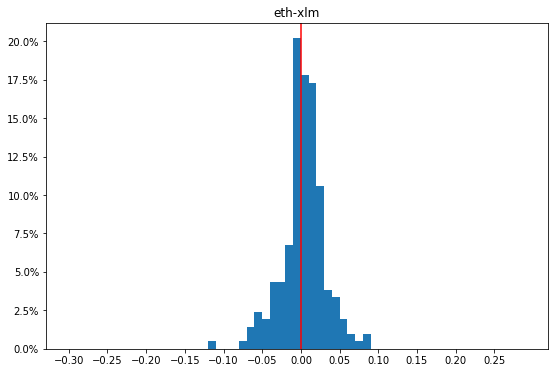

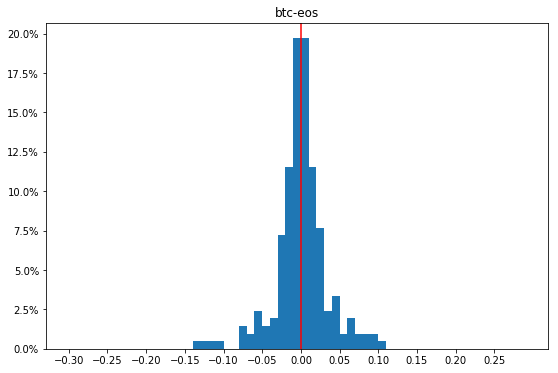

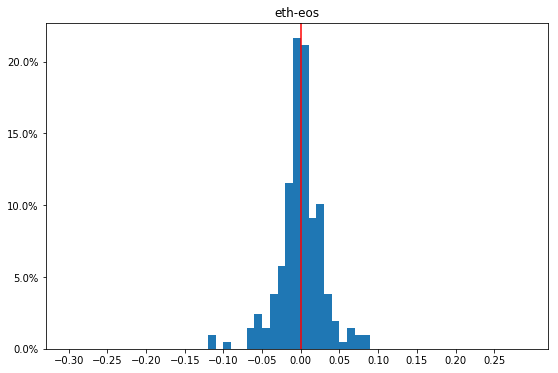

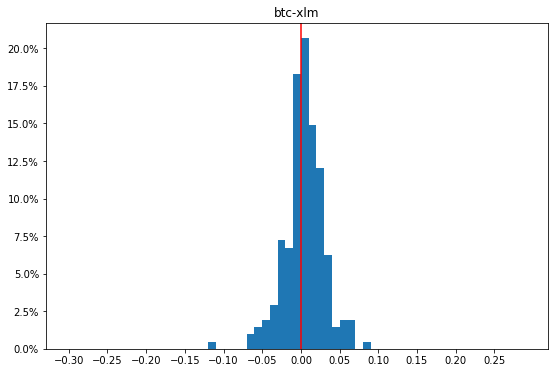

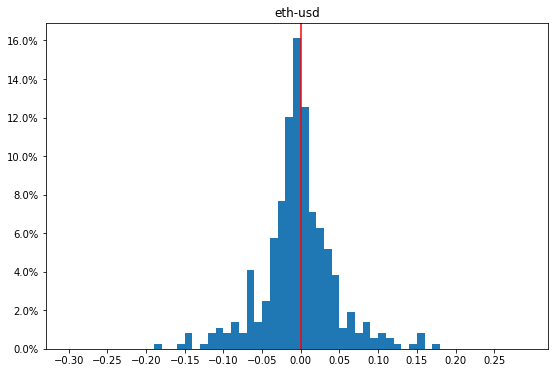

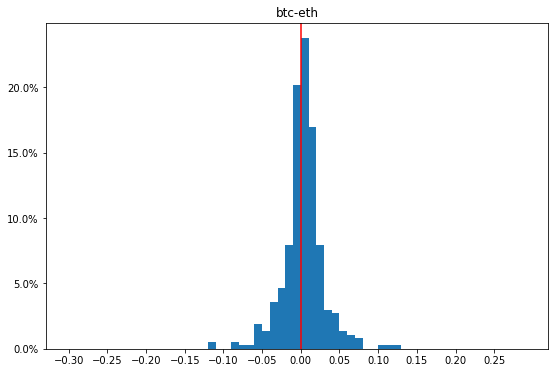

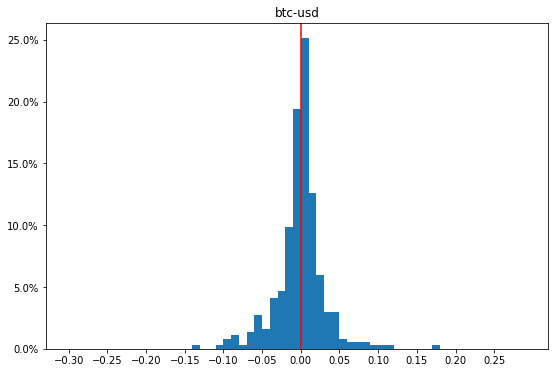

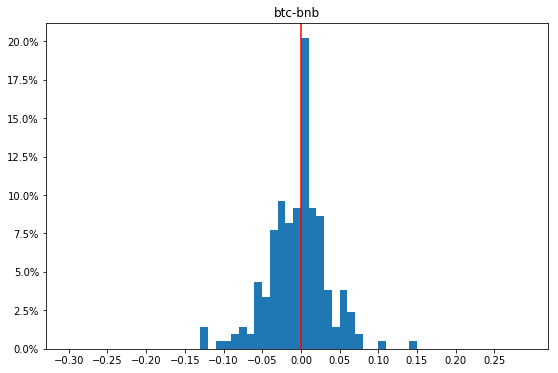

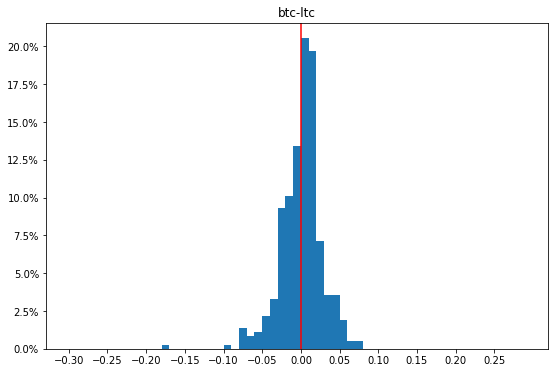

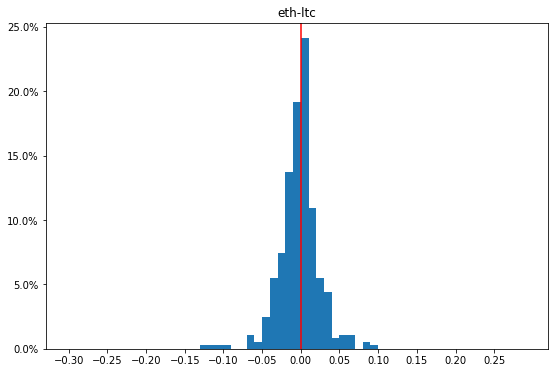

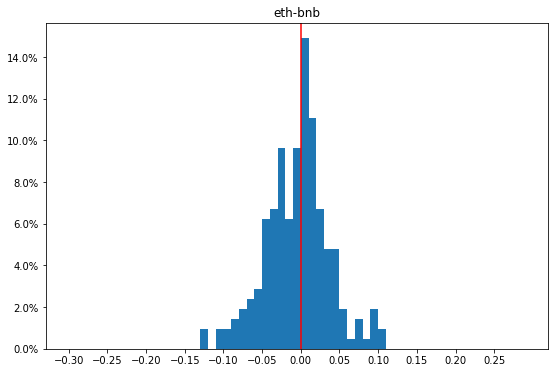

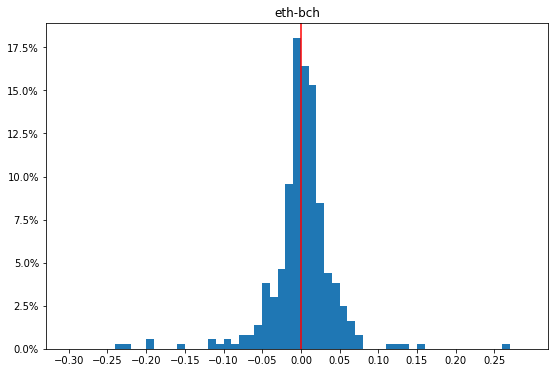

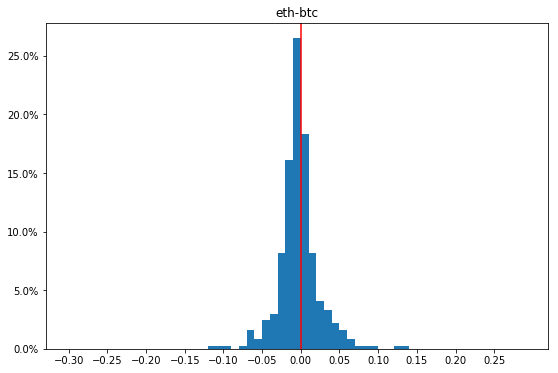

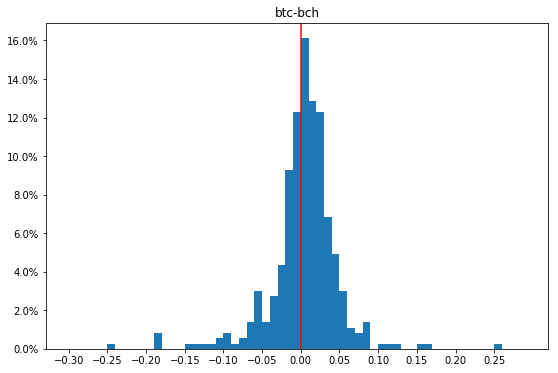

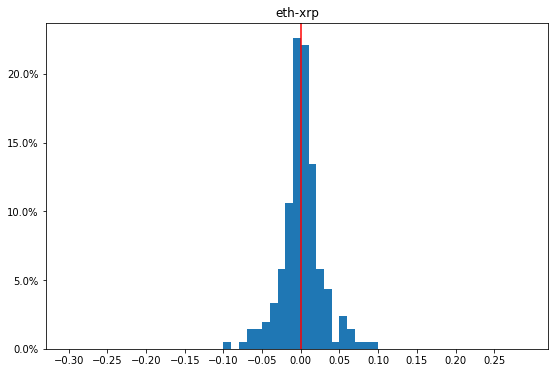

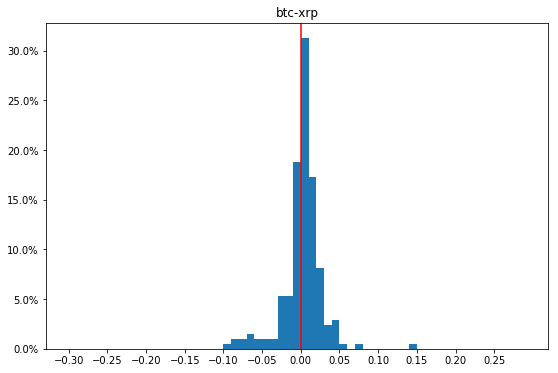

In [23]:
def get_volatility_array(c1, c2):
    df = exchange_rate_csv_to_df(c1, c2)
    volatility_array = df['price_pct_change'].astype('float').values
    return volatility_array

pairs = get_coin_pairs()
for pair in pairs:
    fig = plt.figure(figsize=(9,6))
    c1, c2 = pair[0], pair[1]
    volatility_array = get_volatility_array(c1, c2)
    # y axis percentage
    plt.hist(volatility_array,
             weights=np.ones(len(volatility_array)) / len(volatility_array),
             bins=np.arange(-0.3, 0.3, 0.01))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    
    plt.axvline(x=0, c='r')
    plt.xticks(np.arange(-0.3, 0.3, 0.05))
    plt.title('{}-{}'.format(c1, c2))